# Keyword expansion

In this exercise we are going to use the keyword expansion technique propsoed in `Computer-Assisted Keyword and Document Set Discovery from Unstructured Text` by King, Lam and Roberts (2017), in order to label a dataset of tweets according to whether or not they are related to covid-19.

The idea is to use an initial list of keywords to label the date, and then use supervised learning to expand the list of keywords to get a better sense of how people talk about a topic. It is an iterative approach, meaning that you start with a list of keywords, and expand it, run it again etc. until you saturate the list. The approach also emphasises that you should read some of the text that you label, in order to ensure correct labelling.


This exercise is a python translation of Gregory Eady's R exercise, heavily inspired by the replication material found here: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/FMJDCD.

If interested, you can also see Greg's walk-through of the R version of this code in his video here:
https://gregoryeady.com/SocialMediaDataCourse/readings/Keywords/

### Read in required packages

In [142]:
import pandas as pd
#import pyreadr #package to allow us to read in .rds data files (native R datafile)
from nltk.stem.snowball import SnowballStemmer
import re
from tqdm import tqdm
from collections import OrderedDict
from collections import defaultdict
from collections import namedtuple
import numpy as np
from nltk.stem import PorterStemmer
from nltk.tokenize import WhitespaceTokenizer
import nltk
from sklearn.feature_extraction.text import CountVectorizer
import random
from math import lgamma
from sklearn import linear_model
import matplotlib.pyplot as plt
import datetime

# 1. Load the data

Download the data from the course module on Absalon, and load the data.

In [143]:
#load V2fully_preprocessed
df = pd.read_csv('/Users/stilling/Desktop/collect_process_analyse/processing/V2fully_preprocessed.csv')


In [144]:
#drop all columns summary_stemmed	summary_lemmatized	cleaned_lemmatized
df = df.drop(columns=['summary_stemmed', 'summary_lemmatized', 'cleaned_lemmatized'])

df = df.reset_index(drop=True)

In [145]:
#transform the published_date
df['published_date'] = pd.to_datetime(df['published_date'])
df['published_date'] = df['published_date'].dt.date

In [146]:
df.head()

,title,author,published_date,link,clean_url,summary,rank,country,authors,is_opinion,_score,date_range,summary_no_phrase,lowcase_summary,summary_cleaned,summary_no_whitespace,summary_no_stopwords
0,Trudeau announces help for homeless in Vancouv...,The Canadian Press,2019-02-11,https://nationalpost.com/pmn/news-pmn/canada-n...,nationalpost.com,"This advertisement has not loaded yet, but you...",1127,CA,The Canadian Press,False,87.253510,2019-01-01 to 2019-03-31,His government is providing funding to the Van...,his government is providing funding to the van...,his government is providing funding to the van...,his government is providing funding to the van...,government providing funding vancouver afforda...
1,Prime Minister announces investments for safer...,markets.businessinsider.com,2019-02-11,https://markets.businessinsider.com/news/stock...,businessinsider.com,"VANCOUVER, Feb. 11, 2019 /CNW/ - Every Canadia...",106,US,markets.businessinsider.com,False,87.161575,2019-01-01 to 2019-03-31,", Feb. 11, 2019 // - Every Canadian deserves t...",", feb. 11, 2019 // - every canadian deserves t...",feb every canadian deserves to have a safe and...,feb every canadian deserves to have a safe and...,feb every canadian deserves safe affordable pl...
2,Trudeau announces help for Vancouver homeless ...,The Canadian Press,2019-02-12,https://www.cbc.ca/news/canada/british-columbi...,cbc.ca,"Prime Minister Justin Trudeau, right, walks wi...",300,CA,The Canadian Press,False,83.397830,2019-01-01 to 2019-03-31,"Prime Minister Justin Trudeau, right, walks wi...","prime minister justin trudeau, right, walks wi...",prime minister justin trudeau right walks with...,prime minister justin trudeau right walks with...,prime minister justin trudeau right walks rich...
3,Feds to fund 3 Vancouver temporary modular hou...,The Canadian Press,2019-02-12,https://globalnews.ca/news/4951038/vancouver-t...,globalnews.ca,The federal government announced plans Monday ...,854,CA,The Canadian Press,False,83.028340,2019-01-01 to 2019-03-31,The federal government announced plans Monday ...,the federal government announced plans monday ...,the federal government announced plans monday ...,the federal government announced plans monday ...,federal government announced plans monday deve...
4,Federal fund for rental units won't fix housin...,Robyn Miller,2019-03-20,https://www.cbc.ca/news/canada/ottawa/rental-c...,cbc.ca,"Coun. Catherine McKenney, in orange, speaks at...",300,CA,Robyn Miller,False,82.780230,2019-01-01 to 2019-03-31,"Coun. Catherine McKenney, in orange, speaks at...","coun. catherine mckenney, in orange, speaks at...",coun catherine mckenney in orange speaks at an...,coun catherine mckenney in orange speaks at an...,coun catherine mckenney orange speaks affordab...


# 1.1. Preprocessing

Due to time restraints, the preprocessing code is given below, ready to be run. Take a look at the code to understand what is being done.


Subset the data by removing tweets before 2019 (we are only interested in tweets that may reference COVID-19).

In [147]:
df.reset_index(inplace = True, drop = True)

Save the original text and lowercase the text column.

Do some (but not all) preprocessing by removing tweet elements that we do not care about.


In [148]:
# Remove mentions (posts that start with a "@some_user_name ")
df['summary_cleaned'] = df['summary_cleaned'].str.replace("\\B@\\w+|^@\\w+", "", regex=True)
# Change ampersands to "and"
df['summary_cleaned'] = df['summary_cleaned'].str.replace("&amp;", "and")
# Remove the "RT" and "via" (old retweet style)
df['summary_cleaned'] = df['summary_cleaned'].str.replace("(^RT|^via)((?:\\b\\W*@\\w+)+)", "", regex=True, case=False)
# Remove URLs
df['summary_cleaned'] = df['summary_cleaned'].str.replace("(https|http)?:\\/\\/(\\w|\\.|\\/|\\?|\\=|\\&|\\%)*\\b", "", regex=True)
# Keep ASCII only (removes Cyrillic, Japanese characters, etc.)
df['summary_cleaned'] = df['summary_cleaned'].str.replace("[^ -~]", "", regex=True)
# Remove double+ spaces (e.g. "build   the wall" to "build the wall")
df['summary_cleaned'] = df['summary_cleaned'].str.replace("\\s+", " ", regex=True)
# Remove specific characters Äî and ¬† by replacing them with a white space
df['summary_cleaned'] = df['summary_cleaned'].str.replace("Äî|¬†", " ", regex=True)
# Remove specific symbols and phrases
df['summary_cleaned'] = df['summary_cleaned'].str.replace("Ä¶", " ", regex=True)
df['summary_cleaned'] = df['summary_cleaned'].str.replace("Photo: The Canadian Press", "", regex=True)
# Remove patterns for "Photo: The Canadian Press" and similar phrases
df['summary_cleaned'] = df['summary_cleaned'].str.replace(r"Photo: The Canadian Press", "", regex=True)
# Remove URLs matching a specific pattern
df['summary_cleaned'] = df['summary_cleaned'].str.replace(r"https://media\.socastsrm\.com/wordpress/wp-content/blogs\.dir/\d+/files/\d+/\d+/[a-zA-Z0-9-]+\.mp3", "", regex=True)

With our mostly preprocessed tweets, let us begin building our classifier from chosen keywords.

# 2. Define inclusion and exclusion keywords

You should now define the initial keywords that you want to include and exclude. Keywords to include should reference COVID-19, e.g. "covid19" and/or "coronavirus". We will use these initial keywords to find more keywords relevant to the topic.

1. Define 4 lists: the **first** should contain a seed reference word to be included, the **second** should contain the expanded list of reference words to include (empty to begin with), the **third** should contain a seed reference word to be excluded (can be left empty), and the **fourth** should contain the expanded list of reference words to exclude (empty to begin with).

2. Using `.join`, collapse the two inclusion and exclusion lists, respectively, into strings that can be used as regex OR-operations. The result should be in the form \['dog', 'cat'\] --> 'dog|cat'

3. Use this regex string to create a bool column indicating whether the tweet contains one of your keywords.

4. If you have any exlusions, also find the tweets that contain the excluded keywords (the exclusion list can be left empty).

5. Define a variable that is either 0 or 1, where 1 shows that the tweet contains one or more of your inclusion keywords _and_ does not contain any exclusion keywords. Create a bool column with this.

6. See how many tweets you have labelled as related to COVID-19 so far (how many 0s and how many 1s).

7. Sample 10 tweets labelled as COVID-19, and read the text in them (in the text_original column).

In [149]:
# The keywords that add through the keyword discovery process
# relevant keywords could be lots of things, the choices below just represent one way of doing it

reference_words_seed  = ["canada", "housing crisis", "afford"] #first word we started with
reference_words_expanded = [] #expanded list of keywords (just to show how it works)

In [150]:
# The keywords that add through the keyword discovery process
reference_words_excluded = ["real estate"] #initial
reference_words_excluded_expanded = ["health care","mental health", 
    "budget", "American", "opiod", "election", "homeless", "architecture", "construction", 
    "addict", "encampment", "vote", "shelter", "drug", "campaign", "outreach", "candidate", "survey"
    ] #expanded


In [151]:
# Put the seed words and keywords added through discovery together

reference_words = reference_words_seed + reference_words_expanded
reference_words = "|".join(reference_words)

reference_words_excluded = reference_words_excluded + reference_words_excluded_expanded
reference_words_excluded = "|".join(reference_words_excluded)


In [152]:
reference_words

'canada|housing crisis|afford'

In [153]:
reference_words_excluded

'real estate|health care|mental health|budget|American|opiod|election|homeless|architecture|construction|addict|encampment|vote|shelter|drug|campaign|outreach|candidate|survey'

In [154]:
# Will there be any keywords we want to exclude? this is simply a test
excluded_words = len(reference_words_excluded.replace("|", "")) > 0 #checks if there are more chars than 0, returns a bool

print(excluded_words)

True


In [155]:
# Find tweets that contain any keywords that we want to include and exclude

df['includes'] = df['summary_cleaned'].str.contains(pat = reference_words, regex = True, case = False)
df['excludes'] = df['summary_cleaned'].str.contains(pat = reference_words_excluded, regex = True, case = False)


In [156]:
# Just a bunch of TRUE and FALSE for the posts that include and exclude keywords
df['reference_set'] = (df['includes']== True) & (df['excludes'] == False) #all rows with the included and without the excluded
df['reference_set'] = df['reference_set'] *1 #make into numeric


In [157]:
#how many of each?
df['reference_set'].value_counts()


reference_set
0    62810
1     8784
Name: count, dtype: int64

These are the tweets we have labelled to be about covid-19. Now let us sample some of them.

In [158]:
samp = df.loc[df['reference_set']==1,'summary_cleaned'].sample(5)

In [159]:
for i in samp:
    print("Article:",i)

Article: these are the cheapest neighbourhoods in toronto for buying a condo right now toronto realestate torontorealestate do you ever think about what kind of place you might be able to buy with all the money youve ever spent on rent living in downtown toronto youre over the same amount of time this doesnt mean that buying is anywhere near easy or affordable in the however where the average home now sells for andare keeping many firsttime buyers from securing mortgages on homes over one million condos currentlyselling for an average of 271in the city of toronto have thus become an increasinglypopular solution as of latethe rising cost of rent was a major theme throughout and this trend is likely to continue in driving many prospective buyers to seek more affordable property types reads a new report from the digital brokerage and analysis firm zoocasa read more the situation that caused silicon valley bank to collapse in the course of fortyeight hours was uncommon and its an example o

# 3. Further preprocessing and vectorizing

Next, we need to tokenize the data and preprocess the tokens (as opposed to the preprossesing on the full string as earlier).

We will also remove all the keywords that demarcate exclusion and inclusion from the covid-19 theme. This is becasue we want the model to learn to predict the topic using other, new keywords.

1. Create a new col named "text_preprocessed" - it should be equal the text col, but with the keywords removed (Hint: use `.str.replace()` with `regex = True`).

-----

To spend less time on lessons you have already been through, code for further preprocessing is provided. This code may take a few minutes to run. The steps are:

2. Tokenizing. A whitespace tokenizer is used, since we want to keep words with '-'.

3. Removing any tokens that are only numbers (you can remove more types of tokens if you want - up to you).

4. Remove any empty strings.

5. Stemming.

6. Re-joining the stemmed tokens using a whitespace.

7. Creating a column with the preprocessed sentences.

-----

8. Now you have a column  of sentences made out of stemmed and preprocessed tokens. Use a CountVectorizer to make a document term matrix based on this column. Set `min_df = 10` and `max_df = 0.999`, as well as `stop_words = 'english'` and set an appropriate `ngram_range`.

NB: Do not try to make this DTM into a dataframe or np array, as you will most likely run out of memory. It is a sparse matrix that you can work with in the same way as an np.array.



In [160]:
# We'll remove the keywords from the articles so that the machine learning model
# needs to use the words in each tweet that aren't those keywords to predict
# whether it belongs in the target set or not the target set

remove_keywords_from_articles = True

#make a reg-ex list of all the inclusion and exclusion words

if excluded_words: #if there are exclusion words
    all_current_keywords = reference_words + "|" + reference_words_excluded
else:
    all_current_keywords = reference_words


df['text_preprossed'] = df['summary_cleaned']

if remove_keywords_from_articles:
    df['text_preprossed'] = df['summary_cleaned'].str.replace(all_current_keywords, "", regex = True, case = False)


In [161]:
tokenizer = WhitespaceTokenizer()
ps = PorterStemmer()

In [162]:
pre_prossed_sents =[]
for sent in tqdm(df['text_preprossed']):
    words = tokenizer.tokenize(sent)
    words = [re.sub(r'\d+', '', word) for word in words] #removing tokens that are only words
    words = [x for x in words if x] #removing empty strings
    sent_stem = [ps.stem(word) for word in words]

    sent_done = " ".join(sent_stem)
    pre_prossed_sents.append(sent_done)


100%|██████████| 71594/71594 [10:32<00:00, 113.25it/s]


In [163]:
df['articles_pre_stem'] = pre_prossed_sents

In [164]:
# Consider saving a csv at this time

df.to_csv('/Users/stilling/Desktop/collect_process_analyse/processing/kw_expand_doc_classify/kw_preprocessed.csv')

In [165]:
# if needed
#df = pd.read_csv('MOC_Tweets_preprocessed.csv')


In [166]:
"""The CountVectorizer sets up the rules for how the text data should be transformed into a matrix, specifying things like which words or n-grams to include, 
which ones to ignore, and how to represent them. Then, when you apply the fit_transform method of the CountVectorizer to your actual text data (df['text_pre_stem']), 
it processes the text according to those rules and produces the matrix of token counts, which is stored in the variable corpus. 
This matrix is ready to be used for further analysis or modeling."""

#count vectoriser converts a collection of text documents into matrix of token counts. 
#each row in the matris represents a doc and each column represents a a unique word or n-gram. 
#The value in each cell is the count of the word in the document. 

#min and max df - specifies the upper and lower limits of the frequency of 
#the words to be included in the matrix

#n-gram range - specifies the range of n-grams to be included in the matrix. this indicates we will have bi-grams

#corpus this applies the count vectorizer to the preprocessed text data and transforms it into a matrix


vectorizer = CountVectorizer(min_df = 10,
                           max_df = 0.999,
                           stop_words='english',
                          ngram_range = (1,2)) #set for larger n-grams

corpus = vectorizer.fit_transform(df['articles_pre_stem'])

In [167]:
"""storing both the DTM and the labels in a single dictionary, DTM_dict, you have a convenient way to access and manipulate these two components of the dataset together. 
This organization helps streamline tasks such as model training, 
evaluation, and analysis in natural language processing (NLP) workflows."""

#dict w. two keys
# the DTM key contains the document term matrix generated by the count vectorizer from the 
#observations in the preprocessed set of data

#labels stores observation and whether or not it contains covid-19 (1 or 0) in the reference set of data

DTM_dict = {"DTM":corpus,
               "labels":list(df['reference_set'])}

# 4. Sample training data and make predictions

Let us sample some tweets we will use to train our classifier.

1) Define two lists of indices: One list containing the indices of the tweets in the reference set (those labelled as belonging to the covid-19 topic), and another list containing N sample of tweets not from the reference set (N should be either 2x the amount of tweets in the reference set or 50000, whichever is smaller).

2) You now have 2 lists of indices – use these to subset the Document Term Matrix (where each row represents a tweet, and each column a token) and the reference set column in the dataframe (the labels). Define a train DTM and  a train labels object.

3) Fit a cross validated lasso logistic regression, using the DTM subset as input (X) and the reference subset as labels (y). This means that we are trying to predict whether a tweet is in the reference set using the term frequencies. (Hint:  use sklearn's `linear_model.LogisticRegressionCV()`). This may take some time (approx. 5 min, depending on the size of your train data).

4) Use the fitted model to make predictions on the full DTM, and create a column in the dataframe called `predicted_raw` based on this. (Remember that the rows in the DTM correspond to the rows in the dataframe).

5) The prediction outputs propabilities and not classes, so check the standard deviation of the predicion_raw column - this will check if we actually have some variance in the prediction. This is just a sanity check.

6) Set a threshold of 0.25, and assign 1 or 0 to a new column called `predicted`, depending on whether the probability in `predicted_raw` is >= the threshold. (Note: Keep the threshold low if you want more tweets to get into the target set).

7) Create a column called `set_var`. This variable should be == "Reference" if the observation is in the reference set (our original covid-19 labels), "Target" if it is _predicted_ to be a covid-19 related tweet (1) and "Not target" if it is _predicted_ not to be (0).

8) Create a crosstable of the prediciton and set_var, to see how you model does (hint: use use `pd.crosstab()`). Examine the crosstab - what do the different entries mean?

In [168]:
#count of the number in the reference set
#how many of each?
df['reference_set'].value_counts()

reference_set
0    62810
1     8784
Name: count, dtype: int64

In [169]:
# Determine how many articles to sample for the training data

# Calculate the number of articles to sample for the training data
#reference_set_count = df['reference_set'].value_counts()[1]
#n_search = min(reference_set_count * 5, 50000)

# Display the result
#n_search
#NB: Greg uses *20 - but that would take too long to run for the purposes of this exercise


In [170]:
# reference set (those labelled to be about covid)
# search set which do not belong to the reference set

#refer to covid
reference_ids = list(df[df['reference_set']==1].index)

#do not refer to covid
search_ids = list(df[df['reference_set']==0].index)

In [171]:
import random

# Assuming reference_ids and search_ids are already defined
# reference_ids: indices of articles relevant to housing crisis
# search_ids: indices of articles not relevant to housing crisis

# Calculate the number of articles to sample for the training data
reference_set_count = len(reference_ids)
n_search = min(reference_set_count * 5, 50000, len(search_ids))

# Taking a random sample of the search indices, i.e. those that do not belong to the reference set
search_ids_sample = random.sample(search_ids, k=n_search)

# Combine documents that refer to COVID-19 and those that do not to ensure we have a balanced mix of the two
ids = reference_ids + search_ids_sample  # putting them together to create the full list of training set indices

# Checking amounts
print(len(reference_ids), len(search_ids_sample), len(ids))

8784 43920 52704


In [172]:
"""By combining the indices of tweets relevant to COVID-19 (reference_ids) with a randomly sampled subset of indices from tweets not relevant to COVID-19 
(search_ids_sample), you're ensuring that your training dataset contains a balanced mix of documents referencing COVID-19 and those that do not. 
This balanced representation helps the classification model learn to distinguish between tweets about COVID-19 and those that are not, 
leading to better performance and generalization."""

# Taking a random sample of the search indices, i.e. those that do not belong to the reference set
search_ids_sample = random.choices(search_ids, k=n_search)

#combine documents that refer to covid and those that do not to ensure we have a balances mix of the two
ids = reference_ids + search_ids_sample # putting them together to create the full list of training set indices

# Checking amounts
print(len(reference_ids),len(search_ids_sample),len(ids))

8784 43920 52704


In [173]:
""" DTM train dictionary is created to prepare the data for supervised learning. The input data is the DTM corpus ids, and the output data is the labels ids.
The DTM will be used to learn patterns and make predictions while the labels are the targets the the model will try to predict."""


# Saving the training data in a dict object
DTM_train = {"DTM" : corpus[ids,:],
            "labels": list(df['reference_set'][ids])}

In [174]:
df.head()

,title,author,published_date,link,clean_url,summary,rank,country,authors,is_opinion,...,summary_no_phrase,lowcase_summary,summary_cleaned,summary_no_whitespace,summary_no_stopwords,includes,excludes,reference_set,text_preprossed,articles_pre_stem
0,Trudeau announces help for homeless in Vancouv...,The Canadian Press,2019-02-11,https://nationalpost.com/pmn/news-pmn/canada-n...,nationalpost.com,"This advertisement has not loaded yet, but you...",1127,CA,The Canadian Press,False,...,His government is providing funding to the Van...,his government is providing funding to the van...,his government is providing funding to the van...,his government is providing funding to the van...,government providing funding vancouver afforda...,True,False,1,his government is providing funding to the van...,hi govern is provid fund to the vancouv abl ho...
1,Prime Minister announces investments for safer...,markets.businessinsider.com,2019-02-11,https://markets.businessinsider.com/news/stock...,businessinsider.com,"VANCOUVER, Feb. 11, 2019 /CNW/ - Every Canadia...",106,US,markets.businessinsider.com,False,...,", Feb. 11, 2019 // - Every Canadian deserves t...",", feb. 11, 2019 // - every canadian deserves t...",feb every canadian deserves to have a safe and...,feb every canadian deserves to have a safe and...,feb every canadian deserves safe affordable pl...,True,True,0,feb every canadian deserves to have a safe and...,feb everi canadian deserv to have a safe and a...
2,Trudeau announces help for Vancouver homeless ...,The Canadian Press,2019-02-12,https://www.cbc.ca/news/canada/british-columbi...,cbc.ca,"Prime Minister Justin Trudeau, right, walks wi...",300,CA,The Canadian Press,False,...,"Prime Minister Justin Trudeau, right, walks wi...","prime minister justin trudeau, right, walks wi...",prime minister justin trudeau right walks with...,prime minister justin trudeau right walks with...,prime minister justin trudeau right walks rich...,True,True,0,prime minister justin trudeau right walks with...,prime minist justin trudeau right walk with ri...
3,Feds to fund 3 Vancouver temporary modular hou...,The Canadian Press,2019-02-12,https://globalnews.ca/news/4951038/vancouver-t...,globalnews.ca,The federal government announced plans Monday ...,854,CA,The Canadian Press,False,...,The federal government announced plans Monday ...,the federal government announced plans monday ...,the federal government announced plans monday ...,the federal government announced plans monday ...,federal government announced plans monday deve...,True,True,0,the federal government announced plans monday ...,the feder govern announc plan monday to develo...
4,Federal fund for rental units won't fix housin...,Robyn Miller,2019-03-20,https://www.cbc.ca/news/canada/ottawa/rental-c...,cbc.ca,"Coun. Catherine McKenney, in orange, speaks at...",300,CA,Robyn Miller,False,...,"Coun. Catherine McKenney, in orange, speaks at...","coun. catherine mckenney, in orange, speaks at...",coun catherine mckenney in orange speaks at an...,coun catherine mckenney in orange speaks at an...,coun catherine mckenney orange speaks affordab...,True,True,0,coun catherine mckenney in orange speaks at an...,coun catherin mckenney in orang speak at an ab...


In [175]:
DTM_train['DTM'].shape

(52704, 442774)

In [176]:
# Defining the classifier

#logistic reg with lasso penalty
clf = linear_model.LogisticRegressionCV(penalty="l1", n_jobs = -1, solver = "liblinear", max_iter=10000, verbose = 1)

In [177]:
# Fitting the model. This takes some time.
#X = DTM_train['DTM']
#y = DTM_train['labels']
#clf.fit(X, y)

clf.fit(DTM_train['DTM'], DTM_train['labels'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   1  #CD cycles 1
iter   1  #CD cycles 1
iter   1  #CD cycles 1
iter   4  #CD cycles 1
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   2  #CD cycles 1
iter   2  #CD cycles 1
iter   5  #CD cycles 4
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   3  #CD cycles 1
iter   3  #CD cycles 1
iter   6  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   4  #CD cycles 1
iter   4  #CD cycles 1
iter   7  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 1
iter   5  #CD cycles 3
iter   5  #CD cycles 1
iter   8  #CD cycles 3
iter   5  #CD cycles 2
iter   6  #CD cycles 3
iter   6  #CD cycles 1
iter   6  #CD cycles 3
iter   9  #CD cycles 1
iter   6  #CD cycles 1
iter   7  #CD cycles 1
iter   7  #CD cycles 1
iter   7  #CD cycles 1
iter  10  #CD cycles 1
iter   7  #CD cycles 1
iter   8  #CD cycles 1
iter   8  #CD cycles 1
iter   8  #CD cycles 2
it

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.6min finished


LogisticRegressionCV(max_iter=10000, n_jobs=-1, penalty='l1',
                     solver='liblinear', verbose=1)

In [178]:
# Making predictions on the full dataset

predictions = clf.predict(corpus)

In [179]:
# Calculation the standard deviation of the set of values if all predictions are the same (we don't want this to be zero)
# If so, there is a problem: potentially too few observations in the reference
# set relative to the search set

np.std(predictions)

0.37126864285471417

In [180]:
# Set a threshold to deal with potential classification problems - this is essential for converating 
# the probabilities (continuous) to binary (discrete) predictions.
# If the probability of a tweet being in the reference set is greater than the threshold, it is classified as such.
#(Note: Keep the threshold low if you want more tweets to get into the target set).
threshold = 0.25


In [181]:
# Saving variables so far in a dict

DTM_full = {'DTM':corpus,
            'raw_preds': predictions,
            'preds': (predictions > threshold) * 1 ,
            'reference': list(df['reference_set']==1),
            'reference_ids': reference_ids}

In [182]:
# Predict whether or not each articles is in the reference set based on a predicted
# probability, where Pr(reference_set = 1) > threshold. Keep this low if want
# more tweets to get into the target set

In [183]:
#list that holds categorical labels indicating whether each observation belongs to the reference group, 
#the target class (e.g., housing-related), or is not classified as the target.

set_var = []

for i in range(0,len(DTM_full['preds'])):
    if i in reference_ids: #if the obs is in the reference group
        set_var.append('Reference')

    elif DTM_full['preds'][i] == 1:
        set_var.append('Target')

    elif DTM_full['preds'][i] == 0:
        set_var.append('Not target')

    else:
        set_var.append(None)


In [184]:
#set_var

In [185]:
# Creating a new dataframe of predictions
#create a pandas object containing the predicitions made by the model (stored in the DTM_full(preds) dictionary) / the set_var list
# one column contains the model predictions and the other column contains the categorical labels assigned to each observation (set_var)
pred_df = pd.DataFrame([pd.Series(DTM_full['preds']),pd.Series(set_var)]).T

In [186]:
# Checking performance (only classification of the reference observations are relevant to check)

pd.crosstab(pred_df[0],pred_df[1])


1,Not target,Reference,Target
0,,,
0,59771,3,0
1,0,8781,3039


Here we should predict 1 for a very large majority of instances in our reference set!

In [187]:
# Saving the Reference/Target/Not target in the dict

DTM_full['set_var'] = set_var

# 5. Calculate the log likelihood as in the paper

1) Create 3 sets of indices based on the `set_var` colum: one for "Target", one for "Not target" and one for "Reference".

2) Create 3 objects for the target, not_target and reference sets, based on the DTM. These should be: for each token, how often is the given token in the set, how many documents in the set contains the given token, and the proportion of documents in the set containing the given token. (Hint: see sample code for the target set. If you want to convert to a list and not a matrix object, you can use the `.tolist()[0]`)

3) Create a new dataframe, where each row is a token from the DTM (you can use `vectorizer.get_feature_names()`), with 9 cols for each of the 9 objects you just created.

4) Subset the dataset by removing any observations where the terms do not appear in either the target or not_target set, thus keeping only tokens that were in the original search set (step (a) on page 979).

5) Keywords go in the target list if their proportion is higher among those documents estimated to be in the reference set than not; e.g. if for the word "pandemic", 15% of documents predicted as target contain the word "pandemic" versus only 2% among those in the not_target set (step (b) on page 979). Therefore: create a new column that should be True if the token has a higher or equal proportion in the target set than in the not_target set.

6) Examine the `llik` function provided and look in the paper - what does it do?

7) Calculate the amount of documents in the target and the not_target set.

8) Use the provided function to calculate the log likelihood for each token. Assign this to a new column in the dataframe created in step 3.


### Why calculate this?

1. Identifying Significant Terms: Log likelihood helps identify terms that are significantly associated with a particular category or class of documents. This can be useful in tasks such as sentiment analysis, topic modeling, or document classification, where certain terms may be more indicative of a particular category.

2. Feature Selection: By ranking terms based on their log likelihood values, you can prioritize which terms to include or exclude in further analysis or modeling. This helps in feature selection, where you aim to identify the most informative features for your predictive model.

3. Interpretation: Log likelihood provides a quantitative measure of the strength of association between terms and categories. This allows for better interpretation of results and helps in understanding which terms are driving differences between categories.

4. Hypothesis Testing: Log likelihood can be used for hypothesis testing to determine whether the observed frequencies of terms in different categories are significantly different from what would be expected by chance. This helps in assessing the statistical significance of observed patterns in text data.

In [188]:
# Creating 3 lists of indices creating these lists of indices, 
# preparing your data for subsequent analysis or processing based on the different categories defined by the 'set_var' column.

target_ids = list(pd.Series(DTM_full['set_var']) == 'Target')
not_target_ids = list(pd.Series(DTM_full['set_var']) == 'Not target')
ref_ids = list(pd.Series(DTM_full['set_var']) == 'Reference')

In [189]:
# Creating statistics for the target, not_target and reference sets

target_freq = np.sum(DTM_full['DTM'][target_ids,:],0) #how many times is each token used in the target documents
target_num_docs = np.sum(DTM_full['DTM'][target_ids,:] > 0, axis = 0) #how many target documents does each token appear in
target_num_docs_prop =  target_num_docs / sum(target_ids) #proportion of target docs with each token


not_target_freq = np.sum(DTM_full['DTM'][not_target_ids,:],0) #how many times is each token used in the not_target documents
not_target_num_docs = np.sum(DTM_full['DTM'][not_target_ids,:]> 0,axis = 0) #how many not_target documents does each token appear in
not_target_num_docs_prop =  not_target_num_docs / sum(not_target_ids) #proportion of not_target docs with each token


ref_freq = np.sum(DTM_full['DTM'][ref_ids,:],0) #how many times is each token used in the reference documents
ref_num_docs = np.sum(DTM_full['DTM'][ref_ids,:] > 0, axis = 0) #how many reference documents does each token appear in
ref_num_docs_prop =  ref_num_docs / sum(ref_ids) #proportion of reference docs with each token


# Saving the above in a dict

d = {'target_freq' :target_freq.tolist()[0],
    'target_num_docs': target_num_docs.tolist()[0],
    'target_num_docs_prop': target_num_docs_prop.tolist()[0],
    'not_target_freq':not_target_freq.tolist()[0],
    'not_target_num_docs': not_target_num_docs.tolist()[0],
    'not_target_num_docs_prop': not_target_num_docs_prop.tolist()[0],
    'ref_freq':ref_freq.tolist()[0],
    'ref_num_docs': ref_num_docs.tolist()[0],
    'ref_num_docs_prop': ref_num_docs_prop.tolist()[0]}


In [190]:
# Creating a dataframe based on the dict and token names

df_prop = pd.DataFrame(d, index=vectorizer.get_feature_names_out())


In [191]:
# Subsetting observations that are target or not target at least once (probably all)
df_prop = df_prop.loc[(df_prop['target_freq']> 0) | (df_prop['not_target_freq'] > 0), :]


In [192]:
# Creating a column that is True if the token has a higher or equal proportion in the target set than in the not_target set.
df_prop['target_larger'] = df_prop['target_num_docs_prop'] >= df_prop['not_target_num_docs_prop']


In [193]:
# Taking a look at our new dataframe
df_prop

,target_freq,target_num_docs,target_num_docs_prop,not_target_freq,not_target_num_docs,not_target_num_docs_prop,ref_freq,ref_num_docs,ref_num_docs_prop,target_larger
__,0,0,0.000000,37,21,0.000351,0,0,0.000000,False
__ associ,0,0,0.000000,12,11,0.000184,0,0,0.000000,False
___,9,6,0.001974,922,359,0.006006,27,21,0.002391,False
___ associ,2,2,0.000658,70,68,0.001138,1,1,0.000114,False
___ author,2,2,0.000658,78,73,0.001221,5,5,0.000569,False
...,...,...,...,...,...,...,...,...,...,...
zwibel,0,0,0.000000,13,10,0.000167,0,0,0.000000,False
zxem,1,1,0.000329,12,12,0.000201,2,2,0.000228,True
zxem effmz,1,1,0.000329,12,12,0.000201,2,2,0.000228,True
zytaruksurreynowlead,2,2,0.000658,15,15,0.000251,1,1,0.000114,True


In [194]:
# Likelihood function The function llik calculates the log-likelihood of data under a binomial distribution, using a contingency table approach. 
# It seems especially designed for comparing proportions of two categories (like "target" and "not target") between two groups of data. 
# This kind of calculation is often used in statistical testing, such as the Chi-squared test for independence. 

#target_num_docs: Number of documents classified as "target" in a subset of the data.
#nottarget_num_docs: Number of documents classified as "not target" in the same subset.
#target_num_docs_total: Total number of documents classified as "target" across the entire dataset.
#nottarget_num_docs_total: Total number of documents classified as "not target" across the entire dataset.

def llik(target_num_docs, nottarget_num_docs, target_num_docs_total, nottarget_num_docs_total):
    '''No docstring - you neew to see what it does :) '''
    x1 = ((lgamma(target_num_docs + 1) + lgamma(nottarget_num_docs + 1)) -
           lgamma(target_num_docs + nottarget_num_docs + 1 + 1))
    x2 = ((lgamma(target_num_docs_total - target_num_docs + 1) +
           lgamma(nottarget_num_docs_total - nottarget_num_docs + 1)) -
           lgamma(target_num_docs_total - target_num_docs +
          nottarget_num_docs_total - nottarget_num_docs + 1 + 1))
    llik = x1 + x2
    return llik

In [195]:
# Finding the total number of documents in the target and not_target sets

target_num_docs_total = sum(target_ids)
nottarget_num_docs_total =  sum(not_target_ids)

#print f strings to display the total number of documents in the target and not_target sets
print(f"Number of target docs: {target_num_docs_total}")
print(f"Number of not target docs: {nottarget_num_docs_total}")

Number of target docs: 3039
Number of not target docs: 59771


In [196]:
# Calculating the likelihood for each token

llik_list= []
for i in range(len(df_prop)):
    t =df_prop['target_num_docs'][i] #number of documents in the target set
    nt =df_prop['not_target_num_docs'][i] #number of documents in the not_target set
    l = llik(t,nt,target_num_docs_total,nottarget_num_docs_total) #log likelihood
    llik_list.append(l)



/var/folders/90/qblj6c_55q72j69jhssyx8w00000gn/T/ipykernel_31173/1062549825.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t =df_prop['target_num_docs'][i] #number of documents in the target set
/var/folders/90/qblj6c_55q72j69jhssyx8w00000gn/T/ipykernel_31173/1062549825.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nt =df_prop['not_target_num_docs'][i] #number of documents in the not_target set


In [197]:
# Saving the likelihood scores

df_prop['llik'] = llik_list


# 6. Examine new keywords

1) Show the top 25 keywords based on highest log likelihood, where the share of documents in the target set is higher than in the not_target set (see task 5.5). These are the tokens that are most likely to differentiate between the target and not_target sets (meaning that they help the model predict covid-19 related tweets).

2) Do the same with the not_target - what are these terms representative of?

3) Are there any of these tokens that you want to include in the keywords? Choose 1-3 keywords that you want to include or exclude.

4) For the 1-3 keywords you have found, find tweets that contain the given keyword in the original tweet text in the original dataframe. Read some tweets where the keyword is used in context - do you still want to include or exclude the keyword?

5) Optional: add the new keywords to the original list at the beginning of this exercise in 2.1, and rerun the exercises until here, now including the new keywords. This is how the computer-assisted keyword discovery is used iteratively.


In [198]:
df_prop.loc[df_prop['target_larger'] == True].sort_values('llik',ascending = False).head(50)

,target_freq,target_num_docs,target_num_docs_prop,not_target_freq,not_target_num_docs,not_target_num_docs_prop,ref_freq,ref_num_docs,ref_num_docs_prop,target_larger,llik
abl hous,3079,1485,0.488648,42837,21957,0.367352,6494,4009,0.456398,True,-12091.388761
hous,16115,2631,0.865745,309463,46595,0.779559,33762,7546,0.859062,True,-12109.342381
market,4400,1238,0.407371,60117,18205,0.304579,8320,2962,0.337204,True,-12111.319363
abl,5696,1957,0.643962,88446,32567,0.544863,11931,5231,0.595515,True,-12121.349762
rental,3572,884,0.290885,43362,12382,0.207157,7997,2134,0.242942,True,-12122.992801
intern student,777,153,0.050346,4442,1312,0.021950,2167,442,0.050319,True,-12138.919237
studi permit,138,55,0.018098,475,244,0.004082,341,156,0.017760,True,-12140.927289
price,3064,972,0.319842,49600,15002,0.250991,6152,2263,0.257628,True,-12145.068450
rental market,320,193,0.063508,3098,1965,0.032875,571,376,0.042805,True,-12145.114461
rent,3030,840,0.276407,39072,12725,0.212896,6692,1925,0.219148,True,-12146.928342


**Columns Describing Counts and Proportions:**
- target_freq and target_num_docs: Frequency of the token and the number of documents classified as "target" that contain the token.
- target_num_docs_prop: Proportion of target documents containing the token.
- not_target_freq and not_target_num_docs: Frequency of the token and the number of documents classified as "not target" that contain the token.
- not_target_num_docs_prop: Proportion of not target documents containing the token.
- ref_freq, ref_num_docs, ref_num_docs_prop: These might represent a reference category or overall frequency and proportions of the token, giving additional context.


**Interpreting target_larger:**
This column seems to be a boolean indicating whether the proportion of target documents containing the token is larger than that of not target documents.
- Log-Likelihood (llik) Explanation:
The llik value quantifies how likely the observed distribution of a token across "target" and "not target" categories is, under the assumed statistical model.
- Negative Values: The llik values are negative, which is typical for log-likelihoods because they are often calculating log probabilities, which are less than 1 (thus log of a fraction is negative).
- Magnitude of llik: Larger absolute values (more negative) suggest lower likelihoods, indicating that the observed distribution of the token is less probable under the assumed conditions of the statistical model. This might be used to identify tokens that have significantly different distributions between target and non-target groups, potentially indicating key words that distinguish between these groups.

**Interpretation of llik Values:**
When comparing rows, a more negative llik value indicates a greater divergence from what the model predicts if there were no difference in the token's distribution between target and not target documents. In other words, tokens with highly negative llik values are more distinctive in differentiating between the two categories.
Tokens like "respons", "pro", "case", and "inform" with highly negative llik values suggest they are particularly predictive or indicative of the difference between the two categories.

**Usage:**
These values can be crucial in machine learning (for feature selection), statistical analysis to test hypotheses about word usage in different categories, or refining algorithms that categorize documents based on content.
In summary, llik helps you gauge the statistical strength and uniqueness of tokens in separating or characterizing documents into categories. Tokens with notably lower (more negative) llik values are particularly effective or important in distinguishing between target and non-target documents, suggesting their strong association with one category over the other.

In [199]:
df_prop.loc[df_prop['target_larger'] == False].sort_values('llik',ascending = False).head(25)

,target_freq,target_num_docs,target_num_docs_prop,not_target_freq,not_target_num_docs,not_target_num_docs_prop,ref_freq,ref_num_docs,ref_num_docs_prop,target_larger,llik
ness,25,22,0.007239,52657,23560,0.394171,3,3,0.000342,False,-10825.659416
experienc ness,7,5,0.001645,9898,6433,0.107627,0,0,0.000000,False,-11870.341725
ion,25,23,0.007568,12854,6807,0.113885,8,4,0.000455,False,-11909.470783
rs,10,9,0.002962,10494,4796,0.080240,7,7,0.000797,False,-11971.937773
peopl experienc,19,18,0.005923,6466,4493,0.075170,18,17,0.001935,False,-12013.006530
experienc,309,259,0.085225,19191,11982,0.200465,597,506,0.057605,False,-12033.186055
parti,465,287,0.094439,40070,11314,0.189289,820,545,0.062045,False,-12079.156661
liber,471,246,0.080948,34173,10225,0.171070,1068,648,0.073770,False,-12079.797087
substanc,13,12,0.003949,4456,2610,0.043667,35,27,0.003074,False,-12088.427897
health,1107,443,0.145772,45445,14766,0.247043,1888,1054,0.119991,False,-12089.938242


In [200]:

def see_in_context(term):
    '''Gets the tweets orginial text with the term - also supports regex - seachers the full tect
    only returns tweets not in the orginial reference list'''
    if vectorizer.get_feature_names_out().any():
        subset = df.loc[(df['summary_cleaned'].str.contains(pat = term,regex = True, case = False)) & (df['reference_set'] == False),'summary_cleaned']
        if len(subset) != 0:
            return subset
        else:
            print("This is not a term in the corpus")

    else:
        print("This is not a term in the corpus")



In [201]:
see_in_context("inform") #inserting keyword with highest log-likelihood from 'target_larger' == True (will probably change from run to run)

7        more people will now have a place to call home...
8        baloney meter is housing plan a recipe to bank...
9        feb hard working residents of london deserve t...
10       their frontend loading plan is a recipe to ban...
11       their frontend loading plan is a recipe to ban...
                               ...                        
71575    published nov fourteen minute read this press ...
71586    hope turned to dread when brian flamand opened...
71588    the church building which has been closed sinc...
71592    on aug eight after five years as the officer i...
71593    this is the second of a twopart series on shop...
Name: summary_cleaned, Length: 14400, dtype: object

# 7. Optional: Use your new classifier for downstream tasks

1) Assign a `final_classification` boolean column in the original dataframe, which should be 1 if the tweet contains any of the keywords in the new, complete list and if it does not contain any of the exclusion keywords.

2) Examine the value counts of the political affiliation variable. Assign "Democrat" to the tweets labelled with "Independent" (see the people behind the tweets for reason).

3) Plot the share of tweets labelled as covid-19 relevant by your classifier (y), grouped on days (x) for each party - meaning two lines of covid-19 share across time.

**Hints:** <br>
The pandas `groupby` functionality may be of help to you. <br>
You can also also turn the date ints into so-called datetime objects using this:

`dates =[datetime.datetime(year=int(x[i][0:4]), month=int(x[i][4:6]), day=int(x[i][6:8])) for i in range(len(x))]`

where x is a list of the unique dates as int.


In [202]:
# We saved no exclusion keywords so far, so this is just a look up of the terms in the preprocessed dataset

df['final_calssification'] = df['summary_cleaned'].str.contains(pat = reference_words, regex = True, case = False)


In [203]:
df['final_calssification'].value_counts()

final_calssification
True     63670
False     7924
Name: count, dtype: int64

In [204]:
df.head()

,title,author,published_date,link,clean_url,summary,rank,country,authors,is_opinion,...,lowcase_summary,summary_cleaned,summary_no_whitespace,summary_no_stopwords,includes,excludes,reference_set,text_preprossed,articles_pre_stem,final_calssification
0,Trudeau announces help for homeless in Vancouv...,The Canadian Press,2019-02-11,https://nationalpost.com/pmn/news-pmn/canada-n...,nationalpost.com,"This advertisement has not loaded yet, but you...",1127,CA,The Canadian Press,False,...,his government is providing funding to the van...,his government is providing funding to the van...,his government is providing funding to the van...,government providing funding vancouver afforda...,True,False,1,his government is providing funding to the van...,hi govern is provid fund to the vancouv abl ho...,True
1,Prime Minister announces investments for safer...,markets.businessinsider.com,2019-02-11,https://markets.businessinsider.com/news/stock...,businessinsider.com,"VANCOUVER, Feb. 11, 2019 /CNW/ - Every Canadia...",106,US,markets.businessinsider.com,False,...,", feb. 11, 2019 // - every canadian deserves t...",feb every canadian deserves to have a safe and...,feb every canadian deserves to have a safe and...,feb every canadian deserves safe affordable pl...,True,True,0,feb every canadian deserves to have a safe and...,feb everi canadian deserv to have a safe and a...,True
2,Trudeau announces help for Vancouver homeless ...,The Canadian Press,2019-02-12,https://www.cbc.ca/news/canada/british-columbi...,cbc.ca,"Prime Minister Justin Trudeau, right, walks wi...",300,CA,The Canadian Press,False,...,"prime minister justin trudeau, right, walks wi...",prime minister justin trudeau right walks with...,prime minister justin trudeau right walks with...,prime minister justin trudeau right walks rich...,True,True,0,prime minister justin trudeau right walks with...,prime minist justin trudeau right walk with ri...,True
3,Feds to fund 3 Vancouver temporary modular hou...,The Canadian Press,2019-02-12,https://globalnews.ca/news/4951038/vancouver-t...,globalnews.ca,The federal government announced plans Monday ...,854,CA,The Canadian Press,False,...,the federal government announced plans monday ...,the federal government announced plans monday ...,the federal government announced plans monday ...,federal government announced plans monday deve...,True,True,0,the federal government announced plans monday ...,the feder govern announc plan monday to develo...,True
4,Federal fund for rental units won't fix housin...,Robyn Miller,2019-03-20,https://www.cbc.ca/news/canada/ottawa/rental-c...,cbc.ca,"Coun. Catherine McKenney, in orange, speaks at...",300,CA,Robyn Miller,False,...,"coun. catherine mckenney, in orange, speaks at...",coun catherine mckenney in orange speaks at an...,coun catherine mckenney in orange speaks at an...,coun catherine mckenney orange speaks affordab...,True,True,0,coun catherine mckenney in orange speaks at an...,coun catherin mckenney in orang speak at an ab...,True


In [205]:
# save as v3
df.to_csv('/Users/stilling/Desktop/collect_process_analyse/processing/kw_expand_doc_classify/kw_final.csv')

OSError: [Errno 28] No space left on device

In [137]:
# Checking political affiliations of tweeters

#df.affiliation.value_counts()

In [138]:
# Grouping by affiliation and date to create y values

#y_dem_freq_cov = list(plt_df.loc[df['affiliation'] == 'Democrat',:].groupby(['date']).sum().iloc[:,-1])
#y_dem_freq_total = list(plt_df.loc[df['affiliation'] == 'Democrat',:].groupby(['date']).count().iloc[:,-1])

#y_dem = [i / j for i, j in zip(y_dem_freq_cov,  y_dem_freq_total)]

#y_rep_freq_cov = list(plt_df.loc[df['affiliation'] == 'Republican',:].groupby(['date']).sum().iloc[:,-1])
#y_rep_freq_total = list(plt_df.loc[df['affiliation'] == 'Republican',:].groupby(['date']).count().iloc[:,-1])

#y_rep = [i / j for i, j in zip(y_rep_freq_cov,  y_rep_freq_total)]

In [139]:
# x is the dates
#x = np.sort(plt_df.date.unique()).astype(int).astype(str)


In [140]:
dates =[datetime.datetime(year=int(x[i][0:4]), month=int(x[i][4:6]), day=int(x[i][6:8])) for i in range(len(x))]

NameError: name 'x' is not defined

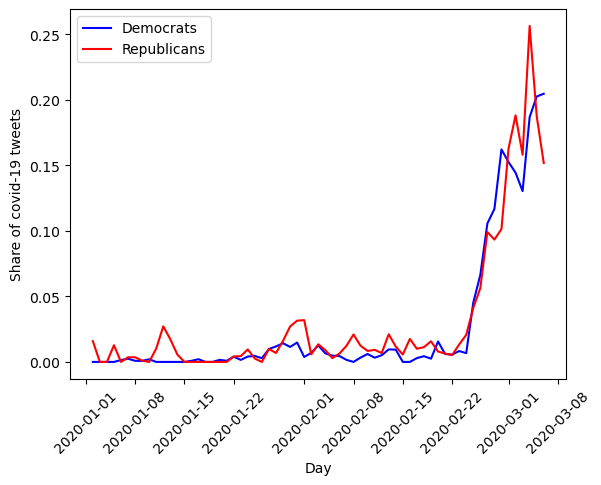

In [66]:
# Plotting the distribution of tweeting about covid-19 across democrats and republicans

plt.plot(dates,y_dem, label = "Democrats", color = "Blue")
plt.plot(dates,y_rep, label = "Republicans", color = "Red")

plt.ylabel("Share of covid-19 tweets")
plt.xlabel('Day')
plt.xticks(rotation=45)

plt.legend()
plt.show()
